# Integrated Mental Health & Cybersecurity Analysis

Datasets
- **Students' Social Media Addiction**
- **Cyber Security Indexes**


## 1. Imports and Data Loading

In [36]:
#Import each library that we use for the project
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from ipywidgets import interact, FloatSlider

import os

project_dir = os.getcwd()

#Make sure this is your path
print(project_dir)

/Users/lanahuang/PycharmProjects/CS439-FinalProject


In [37]:
#Read the social media dataset from the Dataset Folder
social_df = pd.read_csv(os.path.join(project_dir, 'Datasets/studentSocialMediaDataset.csv'))

#Describe and show the dataset
print("Social media dataset shape:", social_df.shape)
social_df.head()

Social media dataset shape: (705, 13)


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [38]:
#Read the cybersecurity dataset from the Dataset Folder
cybersecurity_df = pd.read_csv(os.path.join(project_dir, 'Datasets/cybersecurityDataset.csv'))

#Describe and show the dataset
print("Cybersecurity dataset shape:", cybersecurity_df.shape)
cybersecurity_df.head()

Cybersecurity dataset shape: (192, 6)


,Country,Region,CEI,GCI,NCSI,DDL
0,Afghanistan,Asia-Pasific,1.000,5.20,11.69,19.50
1,Albania,Europe,0.566,64.32,62.34,48.74
2,Algeria,Africa,0.721,33.95,33.77,42.81
3,Andorra,Europe,NaN,26.38,NaN,NaN
4,Angola,Africa,NaN,12.99,9.09,22.69


In [39]:
#Make sure to get rid of any unnecessary columns for each dataset
social_df = social_df[['Country', 'Avg_Daily_Usage_Hours','Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Addicted_Score']].copy()
social_df.head()

,Country,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Addicted_Score
0,Bangladesh,5.2,6.5,6,8
1,India,2.1,7.5,8,3
2,USA,6.0,5.0,5,9
3,UK,3.0,7.0,7,4
4,Canada,4.5,6.0,6,7


In [40]:
cybersecurity_df = cybersecurity_df[['Country', 'Region', 'CEI', 'GCI']].copy()
cybersecurity_df.head()

,Country,Region,CEI,GCI
0,Afghanistan,Asia-Pasific,1.000,5.20
1,Albania,Europe,0.566,64.32
2,Algeria,Africa,0.721,33.95
3,Andorra,Europe,NaN,26.38
4,Angola,Africa,NaN,12.99


## 2. Basic Cleaning & Type Handling

Here we:
- Handle simple missing values
- Impute Ages for Safety Dataset
- Find and fix outliers


#### Social Media Dataset

In [41]:
#Make a copy of the data so we don't mess up the original
social_df_cleaned = social_df.copy()

#Clean the dataframe
for col in social_df_cleaned.columns:
    if social_df_cleaned[col].dtype == object:#If it's a text/string
        social_df_cleaned[col] = social_df_cleaned[col].astype(str).str.strip()
        mode_val = social_df_cleaned[col].mode(dropna=True)#Fill in missing data with the mode
        if len(mode_val) > 0:
            social_df_cleaned[col] = social_df_cleaned[col].fillna(mode_val.iloc[0])

    elif social_df_cleaned[col].isna().any():
        median_val = social_df_cleaned[col].median()#Fill missing value with the median
        social_df_cleaned[col] = social_df_cleaned[col].fillna(median_val)

social_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                705 non-null    object 
 1   Avg_Daily_Usage_Hours  705 non-null    float64
 2   Sleep_Hours_Per_Night  705 non-null    float64
 3   Mental_Health_Score    705 non-null    int64  
 4   Addicted_Score         705 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 27.7+ KB


#### Cybersecurity Dataset

In [42]:
#Copy original dataset and drop null values
cybersecurity_df_cleaned = cybersecurity_df.copy()
cybersecurity_df_cleaned = cybersecurity_df_cleaned.dropna()
cybersecurity_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 0 to 191
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  108 non-null    object 
 1   Region   108 non-null    object 
 2   CEI      108 non-null    float64
 3   GCI      108 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.2+ KB


In [43]:
#Function to find and remove outliers based off bell curve distribution
def find_and_remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    num_outliers = len(outliers)

    df_clean = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)].copy()

    return df_clean, num_outliers, lower_bound, upper_bound

In [44]:
#remove outliers using function created previously
social_original = social_df_cleaned
social_clean = social_df_cleaned

for col in ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night','Mental_Health_Score', 'Addicted_Score']:
    social_clean_temp, num_outliers, lower, upper = find_and_remove_outliers(social_clean, col)
    social_clean = social_clean_temp

print(f"Social Media Dataset:")
print(f"OG rows: {len(social_original)}")
print(f"After outlier removal: {len(social_clean)}")
print(f"Rows removed: {len(social_original) - len(social_clean)} ({(len(social_original) - len(social_clean))/len(social_original)*100:.1f}%)")

Social Media Dataset:
OG rows: 705
After outlier removal: 702
Rows removed: 3 (0.4%)


## 3. Dataset-Specific Exploratory Analysis

We explore each dataset separately before comparing patterns.


#### Social Media Dataset

In [45]:
#Basic statistics
social_df_cleaned.describe()

,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Addicted_Score
count,705.000000,705.000000,705.000000,705.000000
mean,4.918723,6.868936,6.226950,6.436879
std,1.257395,1.126848,1.105055,1.587165
min,1.500000,3.800000,4.000000,2.000000
25%,4.100000,6.000000,5.000000,5.000000
50%,4.800000,6.900000,6.000000,7.000000
75%,5.800000,7.700000,7.000000,8.000000
max,8.500000,9.600000,9.000000,9.000000


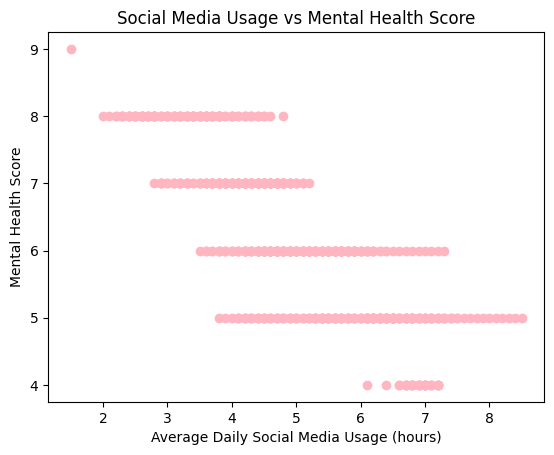

In [46]:
#Scatter plot to show social media usage against mental health score
plt.figure()
plt.scatter(social_df_cleaned["Avg_Daily_Usage_Hours"], social_df_cleaned["Mental_Health_Score"], color="lightpink")
plt.xlabel("Average Daily Social Media Usage (hours)")
plt.ylabel("Mental Health Score")
plt.title("Social Media Usage vs Mental Health Score")
plt.show()

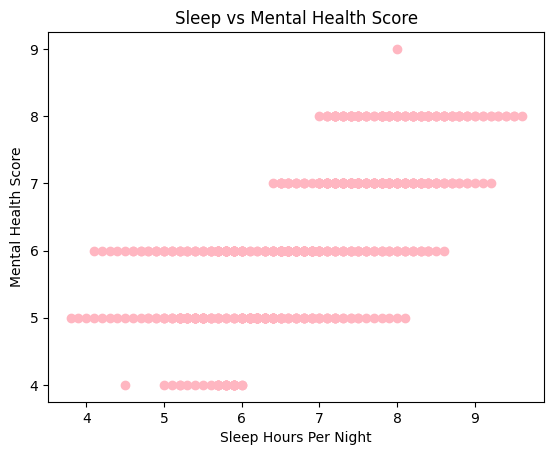

In [47]:
#Scatter plot to show sleep quality against mental health score
plt.figure()
plt.scatter(social_df_cleaned["Sleep_Hours_Per_Night"], social_df_cleaned["Mental_Health_Score"], color="lightpink")
plt.xlabel("Sleep Hours Per Night")
plt.ylabel("Mental Health Score")
plt.title("Sleep vs Mental Health Score")
plt.show()

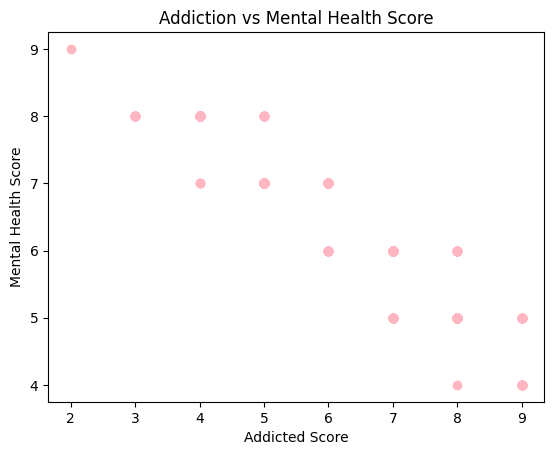

In [48]:
#Scatter plot to show social media addiction against mental health score
plt.figure()
plt.scatter(social_df_cleaned["Addicted_Score"], social_df_cleaned["Mental_Health_Score"], color="lightpink")
plt.xlabel("Addicted Score")
plt.ylabel("Mental Health Score")
plt.title("Addiction vs Mental Health Score")
plt.show()

#### Cybersecurity Dataset

In [49]:
#Basic statistics
cybersecurity_df_cleaned.describe()

,CEI,GCI
count,108.000000,108.000000
mean,0.471861,72.607778
std,0.217246,27.803451
min,0.110000,2.200000
25%,0.279500,56.735000
50%,0.483000,82.055000
75%,0.624250,95.867500
max,1.000000,100.000000


In [50]:
#Find the unique regions from the cybersecurity dataset
cybersecurity_df_cleaned["Region"].unique()

array(['Asia-Pasific', 'Europe', 'Africa', 'South America',
       'North America'], dtype=object)

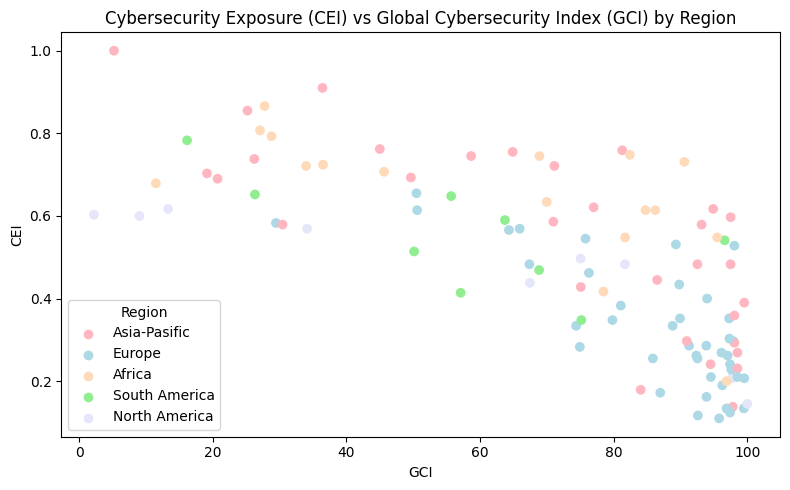

In [51]:
#Scatter plot to show CEI vs GCI based on country and region
region_color_mapping = {
    "Asia-Pasific": "lightpink",
    "Europe": "lightblue",
    "Africa": "peachpuff",
    "South America": "lightgreen",
    "North America": "lavender"
}

#keeps track of each country's region and color
plot_colors = []
for i in range(len(cybersecurity_df)):
    region = cybersecurity_df.iloc[i]["Region"]
    if region in region_color_mapping:
        plot_colors.append(region_color_mapping[region])

plt.figure(figsize=(8, 5))
plt.scatter(cybersecurity_df["GCI"], cybersecurity_df["CEI"], c=plot_colors)
plt.title("Cybersecurity Exposure (CEI) vs Global Cybersecurity Index (GCI) by Region")
plt.xlabel("GCI")
plt.ylabel("CEI")
for region in region_color_mapping:
    plt.scatter([], [], color=region_color_mapping[region], label=region)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


## 4. Predictive Modelling
We started by merging the data set on "Country" before doing the regression models.

Model Testing:
- Linear Regression
- Single Variable Random Forest
- Multi-Variable Random Forest


In [52]:
#merge dataset by the country
merged_df = pd.merge(social_df_cleaned, cybersecurity_df_cleaned, on='Country', how='inner')

print("Merged dataset info:")
print(merged_df.info())
print(f"Number of unique countries in merged dataset: {merged_df['Country'].nunique()}")
merged_df.head()

Merged dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                594 non-null    object 
 1   Avg_Daily_Usage_Hours  594 non-null    float64
 2   Sleep_Hours_Per_Night  594 non-null    float64
 3   Mental_Health_Score    594 non-null    int64  
 4   Addicted_Score         594 non-null    int64  
 5   Region                 594 non-null    object 
 6   CEI                    594 non-null    float64
 7   GCI                    594 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 37.3+ KB
None
Number of unique countries in merged dataset: 84


,Country,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Addicted_Score,Region,CEI,GCI
0,Bangladesh,5.2,6.5,6,8,Asia-Pasific,0.759,81.27
1,India,2.1,7.5,8,3,Asia-Pasific,0.597,97.50
2,Canada,4.5,6.0,6,7,North America,0.207,97.67
3,Australia,7.2,4.5,4,9,Asia-Pasific,0.131,97.47
4,Germany,1.5,8.0,9,2,Europe,0.241,97.41


In [53]:
#view correlation between variables
print("Correlation matrix:")
correlation_matrix = merged_df[['Mental_Health_Score', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score', 'CEI']].corr()
correlation_matrix

Correlation matrix:


,Mental_Health_Score,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Addicted_Score,CEI
Mental_Health_Score,1.000000,-0.782672,0.695227,-0.948282,-0.458775
Avg_Daily_Usage_Hours,-0.782672,1.000000,-0.797074,0.807915,0.342080
Sleep_Hours_Per_Night,0.695227,-0.797074,1.000000,-0.729716,-0.435410
Addicted_Score,-0.948282,0.807915,-0.729716,1.000000,0.445372
CEI,-0.458775,0.342080,-0.435410,0.445372,1.000000


In [54]:
#Prep data for Linear Regression
X = merged_df[['Mental_Health_Score']]
y = merged_df['CEI']

#for reproducibility set random_state to 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 475
Testing set size: 119


In [55]:
#Scale for the Linear Regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
#Create the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

#Print out model evaluation metrics
print("Linear Regression Model")
print(f"R-squared Score: {r2_linear:.4f}")
print(f"Mean Squared Error: {mse_linear:.4f}")
print(f"Mean Absolute Error: {mae_linear:.4f}")

Linear Regression Model
R-squared Score: 0.2151
Mean Squared Error: 0.0343
Mean Absolute Error: 0.1458


In [57]:
#Analyze the correlation between CEI and Mental Health Score
print("Correlation between CEI and Mental Health Score:")

corr = merged_df['CEI'].corr(merged_df[col])

print(f"CEI vs Mental Health Score: {corr:.4f}")

Correlation between CEI and Mental Health Score:
CEI vs Mental Health Score: 0.4454


In [58]:
#Prep and split data for single variable random forest regression
X = merged_df[['Mental_Health_Score']]
y = merged_df['CEI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 475 samples
Testing set size: 119 samples


In [59]:
#Scale and train single variable random forest regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Changed n_estimators from 100 to 250
#Set random_state to 42 for reproducibility
model = RandomForestRegressor(n_estimators=250, random_state=42)
model.fit(X_train_scaled, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",250
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [60]:
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#Print evaluation metrics
print("Single Variable Random Forest Regression Model")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Single Variable Random Forest Regression Model
R-squared Score: 0.2104
Mean Squared Error: 0.0345
Mean Absolute Error: 0.1469


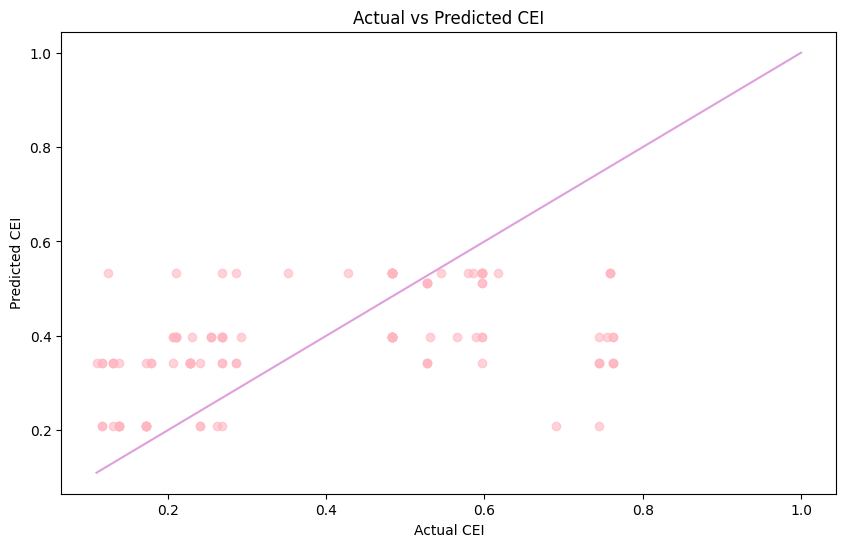

In [61]:
#scatter plot to visualize different between the predicted and the actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="lightpink")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="plum")
plt.xlabel('Actual CEI')
plt.ylabel('Predicted CEI')
plt.title('Actual vs Predicted CEI')
plt.show()

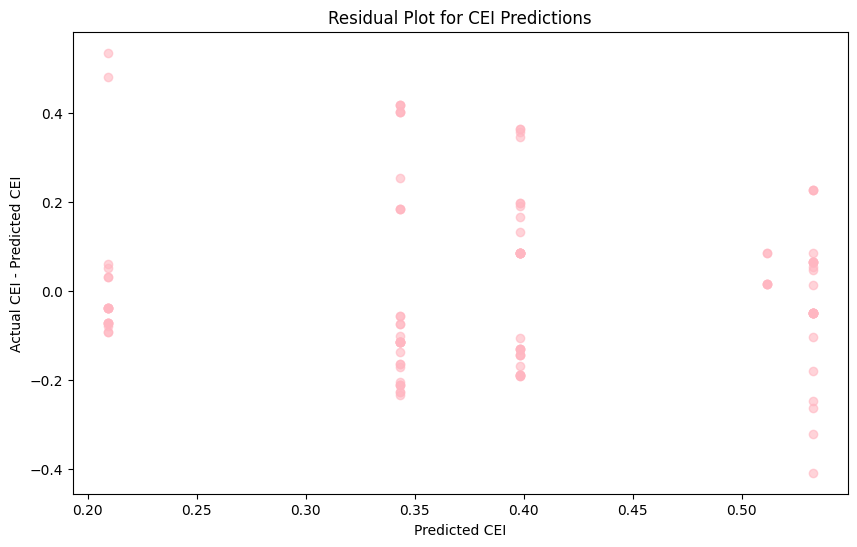

In [62]:
#Scatter plot for the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="lightpink")
plt.xlabel('Predicted CEI')
plt.ylabel('Actual CEI - Predicted CEI')
plt.title('Residual Plot for CEI Predictions')
plt.show()

In [63]:
#Create and train Multi-Variable Random Tree Model
#Update the X variable to include multiple predictors
X_multi = merged_df[['Mental_Health_Score', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Addicted_Score']]
y_multi = merged_df['CEI']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

In [64]:
#Scale and train random Forest Regressor
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

#Changed n_estimators from 100 to 300
#Set random_state to 42 for reproducibility
model_multi = RandomForestRegressor(n_estimators=300, random_state=42)
model_multi.fit(X_train_multi_scaled, y_train_multi)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [65]:
y_pred_multi = model_multi.predict(X_test_multi_scaled)
r2_multi = r2_score(y_test_multi, y_pred_multi)
mse_multi = mean_squared_error(y_test_multi, y_pred_multi)
mae_multi = mean_absolute_error(y_test_multi, y_pred_multi)

#Print evaluation metrics
print("Multi-Variable Random Forest Regression Model")
print(f"R-squared Score: {r2_multi:.4f}")
print(f"Mean Squared Error: {mse_multi:.4f}")
print(f"Mean Absolute Error: {mae_multi:.4f}")

Multi-Variable Random Forest Regression Model
R-squared Score: 0.3335
Mean Squared Error: 0.0291
Mean Absolute Error: 0.1239


In [66]:
#Analyze the correlation between CEI and each predictor
print("Correlation between CEI and each predictor:")

for col in X_multi.columns:
    corr = merged_df['CEI'].corr(merged_df[col])
    print(f"CEI vs {col}: {corr:.4f}")

Correlation between CEI and each predictor:
CEI vs Mental_Health_Score: -0.4588
CEI vs Avg_Daily_Usage_Hours: 0.3421
CEI vs Sleep_Hours_Per_Night: -0.4354
CEI vs Addicted_Score: 0.4454


In [67]:
#Compare each model against each other using their evaluation metrics
comparison_df = pd.DataFrame({'Model': ['Linear Regression','Single Variable Random Forest', 'Multi-Variable Random Forest'],'R-squared': [r2_linear, r2, r2_multi], 'MSE': [mse_linear, mse, mse_multi], 'MAE': [mae_linear, mae, mae_multi]})

print("Model Comparison")
comparison_df

Model Comparison


,Model,R-squared,MSE,MAE
0,Linear Regression,0.215074,0.034305,0.145841
1,Single Variable Random Forest,0.210353,0.034511,0.146929
2,Multi-Variable Random Forest,0.333460,0.029131,0.123902


In [68]:
#Find the min and max for each predictor because that's what the sliders will be
mental_health_min = merged_df['Mental_Health_Score'].min()
mental_health_max = merged_df['Mental_Health_Score'].max()

usage_min = merged_df['Avg_Daily_Usage_Hours'].min()
usage_max = merged_df['Avg_Daily_Usage_Hours'].max()

sleep_min = merged_df['Sleep_Hours_Per_Night'].min()
sleep_max = merged_df['Sleep_Hours_Per_Night'].max()

addiction_min = merged_df['Addicted_Score'].min()
addiction_max = merged_df['Addicted_Score'].max()

In [69]:
#Create function for the sliders that will predict CEI based on user inputted mental health score, social media usage, sleep, and addiction
#It uses the multiple variable random forest regression model that we created earlier
def predict_cei(mental_health, usage, sleep, addiction):
    row_dict = {'Mental_Health_Score': [mental_health], 'Avg_Daily_Usage_Hours': [usage], 'Sleep_Hours_Per_Night': [sleep],'Addicted_Score': [addiction]}
    row = pd.DataFrame(row_dict)
    row_scaled = scaler_multi.transform(row)
    prediction = model_multi.predict(row_scaled)[0]

    if prediction > 0.70:
        level = "High CEI Risk"
    elif prediction > 0.40:
        level = "Moderate CEI Risk"
    else:
        level = "Low CEI Risk"

    print(f"Predicted CEI: {prediction:.3f}")
    print(f"Risk Level: {level}")

In [70]:
#Enable the slider
interact(predict_cei,
    mental_health=FloatSlider(
        value=merged_df["Mental_Health_Score"].mean(),
        min=mental_health_min, max=mental_health_max, step=0.1,
        description="Mental Health Score"
    ),
    usage=FloatSlider(
        value=merged_df["Avg_Daily_Usage_Hours"].mean(),
        min=usage_min, max=usage_max, step=0.1,
        description="Daily Usage Hours"
    ),
    sleep=FloatSlider(
        value=merged_df["Sleep_Hours_Per_Night"].mean(),
        min=sleep_min, max=sleep_max, step=0.1,
        description="Sleep Hours"
    ),
    addiction=FloatSlider(
        value=merged_df["Addicted_Score"].mean(),
        min=addiction_min, max=addiction_max, step=0.1,
        description="Addiction Score"
    )
)

interactive(children=(FloatSlider(value=6.328282828282828, description='Mental Health Score', max=9.0, min=4.0…

<function __main__.predict_cei(mental_health, usage, sleep, addiction)>